<a href="https://colab.research.google.com/github/RISHOBGHOSH/Codes-of-mySQL/blob/main/LunarTech__CaseStudy_AB_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

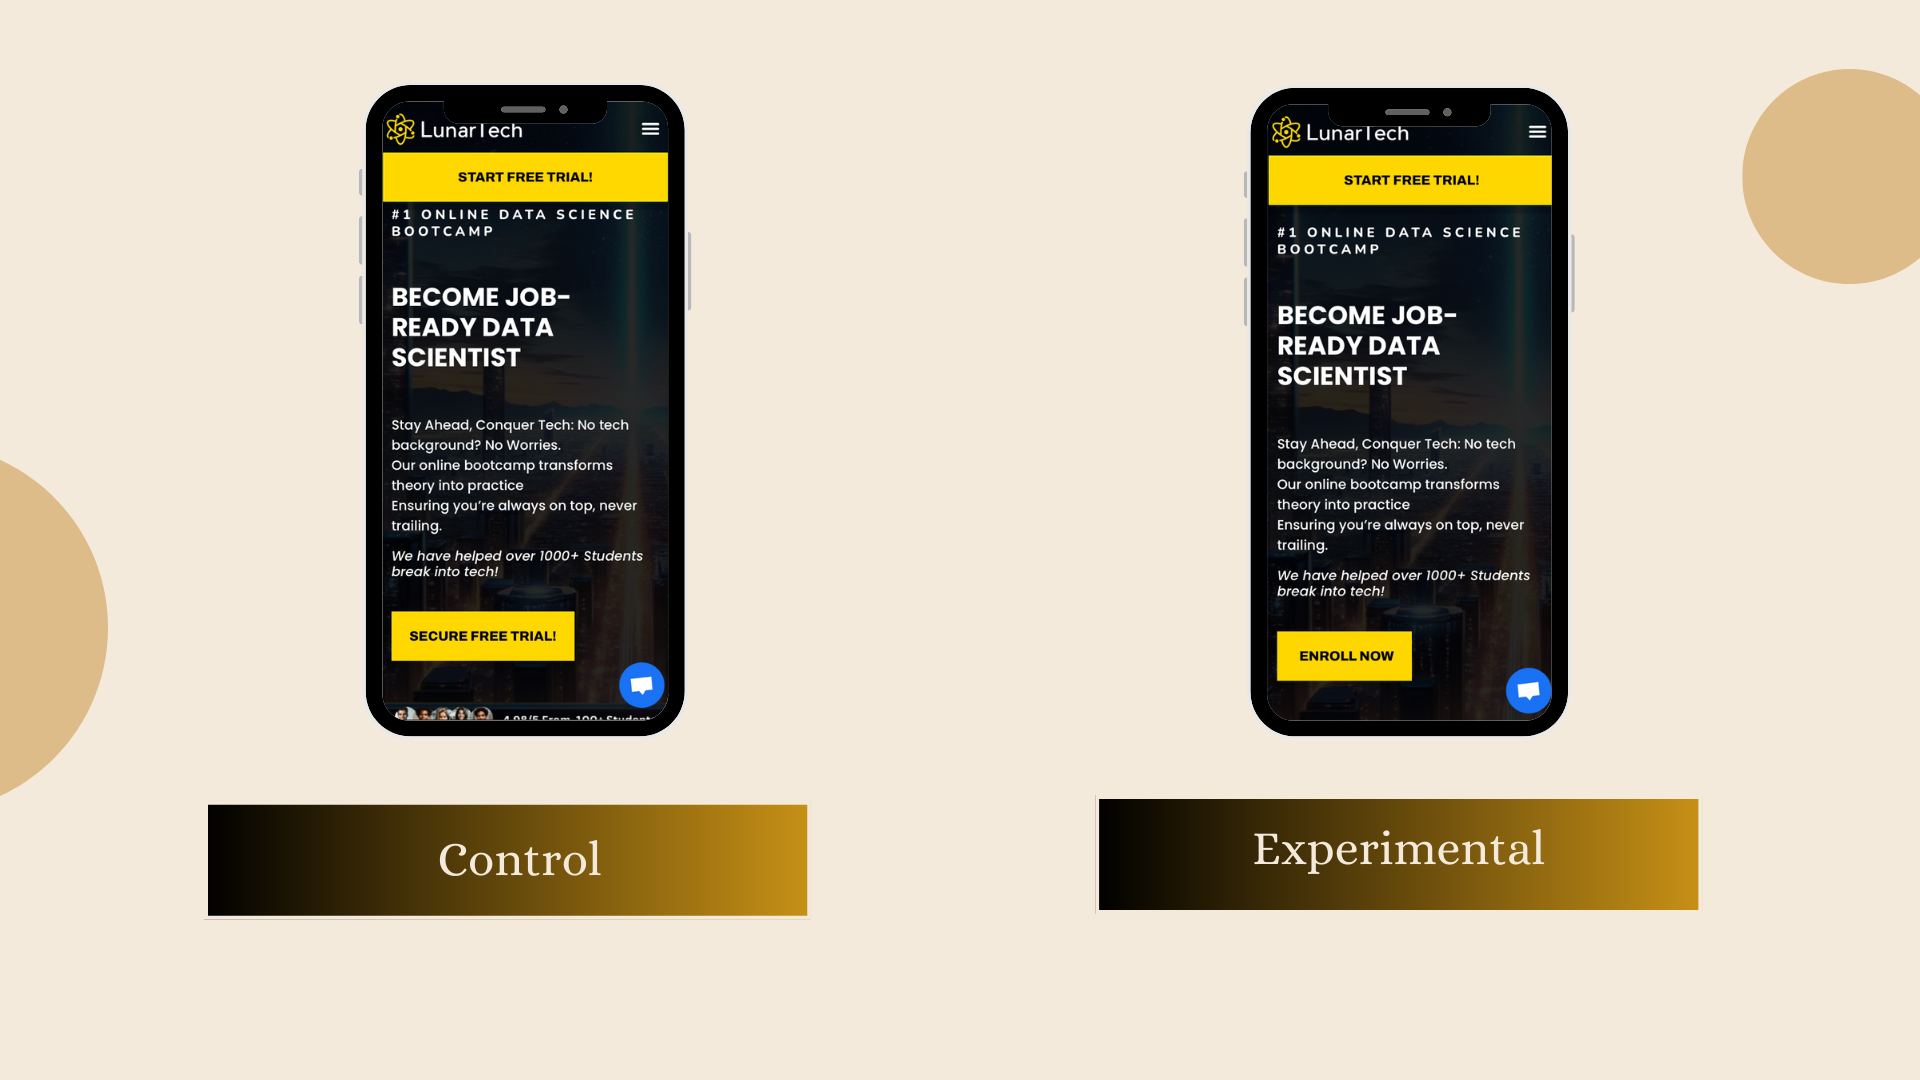

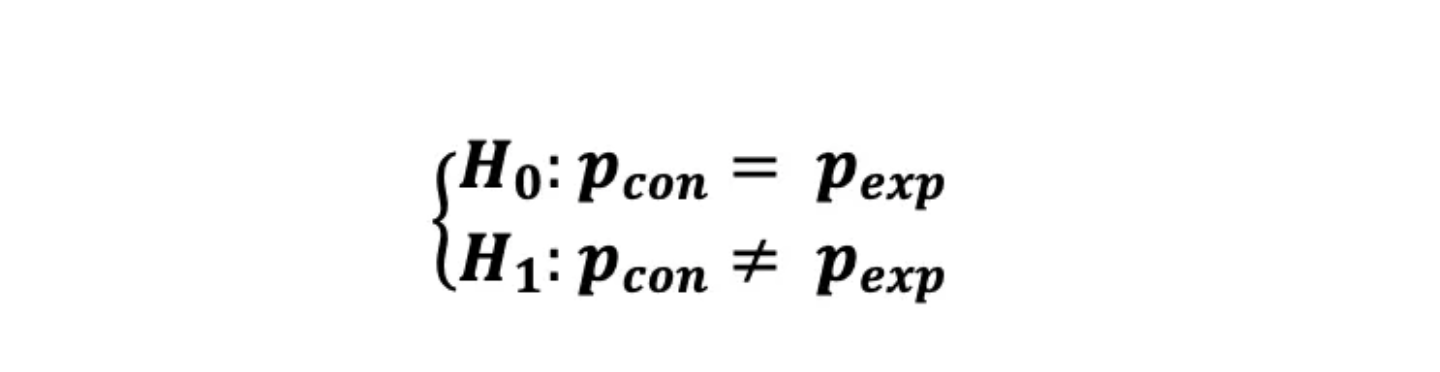

#Data Download from
https://github.com/TatevKaren/CaseStudies/blob/main/AB%20Testing/ab_test_click_data%20(1).csv

# Loading our CTR Data for AB Test

In [ ]:
# Load the data from the CSV file
df_ab_test = pd.read_csv('ab_test_click_data (1).csv')

# Display the first few rows of the DataFrame to confirm it's loaded correctly
print(df_ab_test.head())
print(df_ab_test.describe())
print(df_ab_test.groupby("group").sum("click"))


            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.405250
std     5773.647028      0.490953
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000
         user_id  click
group                  
con    150005000   1989
exp     50005000   6116


A simple bar chart showing the total clicks versus no-clicks in each group can provide a clear visual comparison of user engagement.

group
con    10000
exp    10000
dtype: int64


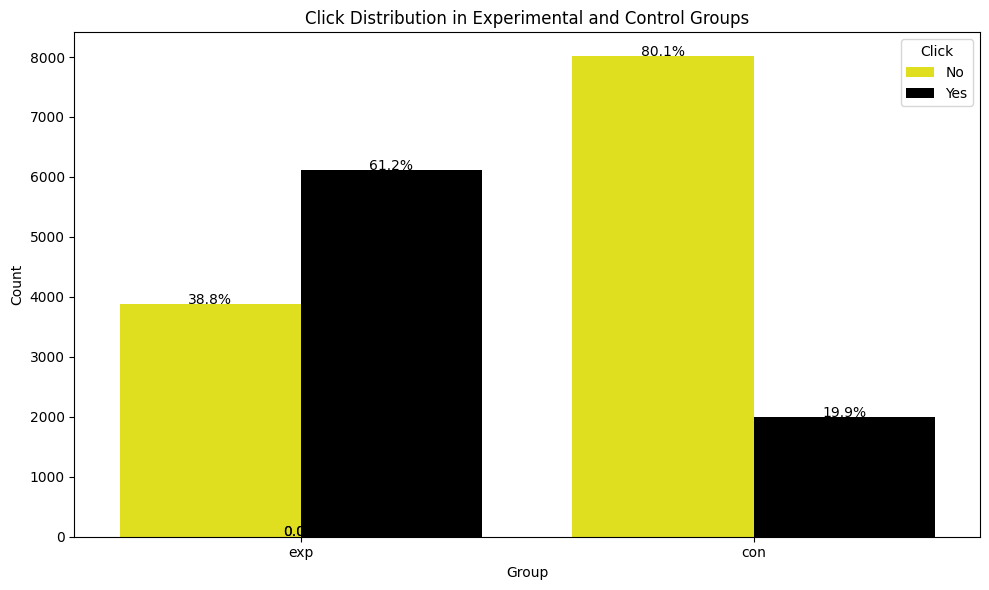

In [ ]:
# Custom palette for yellow and black
palette = {0: 'yellow', 1: 'black'}  # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title('Click Distribution in Experimental and Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate the percentages and annotate the bars
group_counts = df_ab_test.groupby(['group']).size()
print(group_counts)
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height / total
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{percentage:.1f}%', ha="center", color='black', fontsize=10)

plt.tight_layout()
plt.show()

# Parameters of the Model from Power Analysis

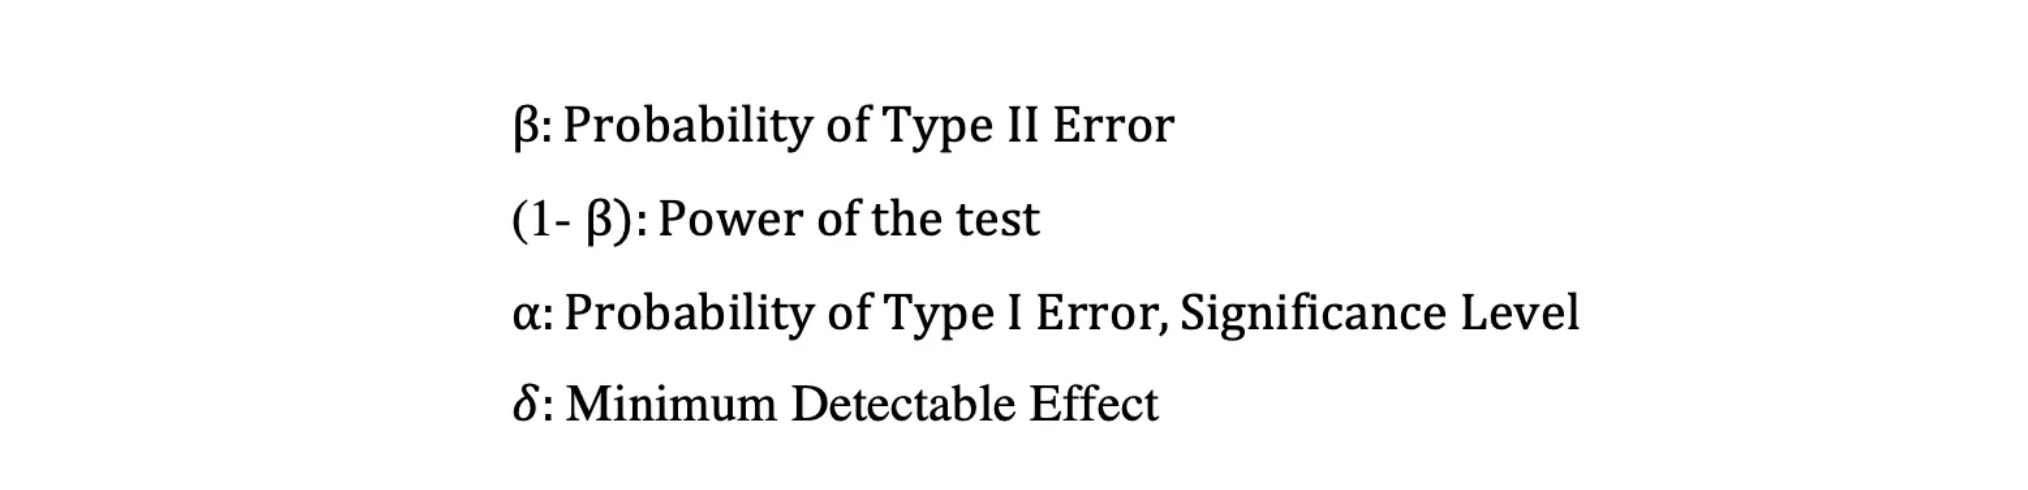


In [ ]:
alpha = 0.05 # 5%
print("Alpha: significance level is:", alpha )

delta = 0.1 # 10%
print("Delta: minimum detectable effect is:", delta )

Alpha: significance level is: 0.05
Delta: minimum detectable effect is: 0.1


# Calculating total number of clicks per group by summing clicks



In [ ]:
N_con = df_ab_test[df_ab_test["group"] == "con"].count()[0]
N_exp = df_ab_test[df_ab_test["group"] == "exp"].count()[0]

# calculating the total number of clicks per group by summing 1's
X_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
X_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

# printing this for visibility
print(df_ab_test.groupby("group")["click"].sum())
print("Number of user in Control: ", N_con)
print("Number of users in Experimental: ", N_exp)
print("Number of CLicks in Control: ", X_con)
print("Number of CLicks in Experimental: ", X_exp)


group
con    1989
exp    6116
Name: click, dtype: int64
Number of user in Control:  10000
Number of users in Experimental:  10000
Number of CLicks in Control:  1989
Number of CLicks in Experimental:  6116


# Calculating Pooled Estimates for Clicks per Group


In [ ]:
# computing the estimate of click probability per group
p_con_hat = X_con/N_con
p_exp_hat = X_exp/N_exp
print("Click Probability in Control Group:", p_con_hat)
print("Click Probability in Experimental Group:", p_exp_hat)

# computing the estimate of pooled clicked probability
p_pooled_hat = (X_con+X_exp)/(N_con + N_exp)
print("Pooled Click Probability:", p_pooled_hat)

Click Probability in Control Group: 0.1989
Click Probability in Experimental Group: 0.6116
Pooled Click Probability: 0.40525


# Calculating Pooled Variance

In [ ]:
# computing the estimate of pooled variance
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/N_con + 1/N_exp)
print("p^_pooled is: ", p_pooled_hat)
print("pooled_variance is: ", pooled_variance)

p^_pooled is:  0.40525
pooled_variance is:  4.82044875e-05


# Calculating Standard Error and Test Statistics

In [ ]:
# computing the standard error of the test
SE = np.sqrt(pooled_variance)
print("Standard Error is: ", SE)

# computing the test statistics of Z-test
Test_stat = (p_con_hat - p_exp_hat)/SE
print("Test Statistics for 2-sample Z-test is:", Test_stat)

# critical value of the Z-test
Z_crit = norm.ppf(1-alpha/2)
print("Z-critical value from Standard Normal distribution: ", Z_crit)

Standard Error is:  0.006942945160376826
Test Statistics for 2-sample Z-test is: -59.44163326469381
Z-critical value from Standard Normal distribution:  1.959963984540054


# Calculating p_values of the Z-test

* A low p-value (p ≤ 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.
* A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.

In [ ]:
#calculating p value
p_value = 2 * norm.sf(abs(Test_stat))

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.

    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.

    Returns:
    - Prints the assessment of statistical significance.
    """

    # Print the rounded p-value to 3 decimal places
    print(f"P-value of the 2-sample Z-test: {(p_value)}")

    # Determine statistical significance
    if p_value <= alpha:
        print("There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.")
    else:
        print("There is no statistical significance, suggesting that the observed differences between the groups could have occurred by chance. This implies that the changes in the experimental group do not have a substantial effect compared to the control group.")



is_statistical_significance(p_value, alpha)

P-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that the observed differences between the groups are unlikely to have occurred by chance alone. This suggests that the changes in the experimental group have a real effect compared to the control group.


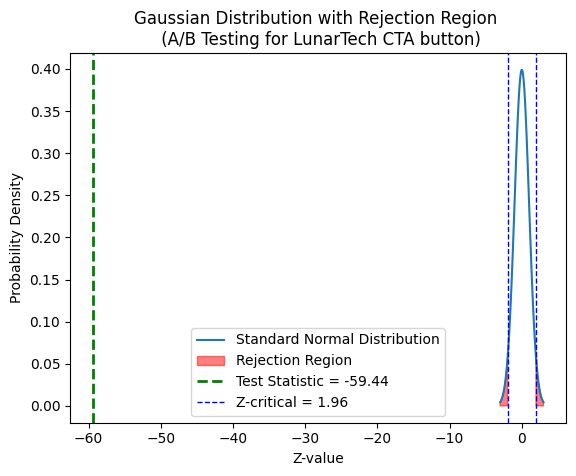

In [ ]:
# Parameters for the standard normal distribution
mu = 0  # Mean
sigma = 1  # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)


# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > Z_crit) | (x < -Z_crit), color='red', alpha=0.5, label='Rejection Region')
# Adding Test Statistic
plt.axvline(Test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {Test_stat:.2f}')
# Adding Z-critical values
plt.axvline(Z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'Z-critical = {Z_crit:.2f}')
plt.axvline(-Z_crit, color='blue', linestyle='dashed', linewidth=1)

# Adding labels and title
plt.xlabel('Z-value')
plt.ylabel('Probability Density')
plt.title('Gaussian Distribution with Rejection Region \n (A/B Testing for LunarTech CTA button)')
plt.legend()
# Show plot
plt.show()

# Calculating Confidence Interval of the test

In [ ]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
CI = [
    round((p_exp_hat - p_con_hat) - SE*Z_crit, 3),  # Lower bound of the CI, rounded to 3 decimal places
    round((p_exp_hat - p_con_hat) + SE*Z_crit, 3)   # Upper bound of the CI, rounded to 3 decimal places
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is: ", CI)

# Here, the confidence interval provides a range of values within which the true difference between the experimental and control group proportions is likely to lie with a certain level of confidence (e.g., 95%).


Confidence Interval of the 2 sample Z-test is:  [0.399, 0.426]


# Testing for Practical Significance in A/B Testing

In [ ]:
def is_Practically_significant(delta, CI_95):
    """
    We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE) parameter from the Power Analysis.

    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.

    Returns:
    - Prints whether the experiment has practical significance based on the MDE and CI.
    """

    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = CI_95[0]

    # Check if the lower bound of the CI is greater than or equal to delta
    if delta >= lower_bound_CI:
        print(f"We have practical significance! \nWith MDE of {delta}, The difference between Control and Experimental group is practically significant.")
        return True
    else:
        print("We don't have practical significance! \nThe difference between Control and Experimental group is not practically significant.")
        return False



# Call the function
significance = is_Practically_significant(delta, CI_95)
print("Lower bound of 95% confidence interval is: ", CI_95[0])


We have practical significance! 
With MDE of 0.1, The difference between Control and Experimental group is practically significant.
Lower bound of 95% confidence interval is:  0.04
